In [1]:
%load_ext autoreload
%autoreload 2

In [3]:

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from bridgeop.data.synthetic import Ellipse, Ellipsoid
from bridgeop.diffusion.sde import SDEFactory
from bridgeop.utils.solver import EulerMaruyama, Wiener
from bridgeop.utils.trainer import TrainerModule, ScoreModel

### Ellipse

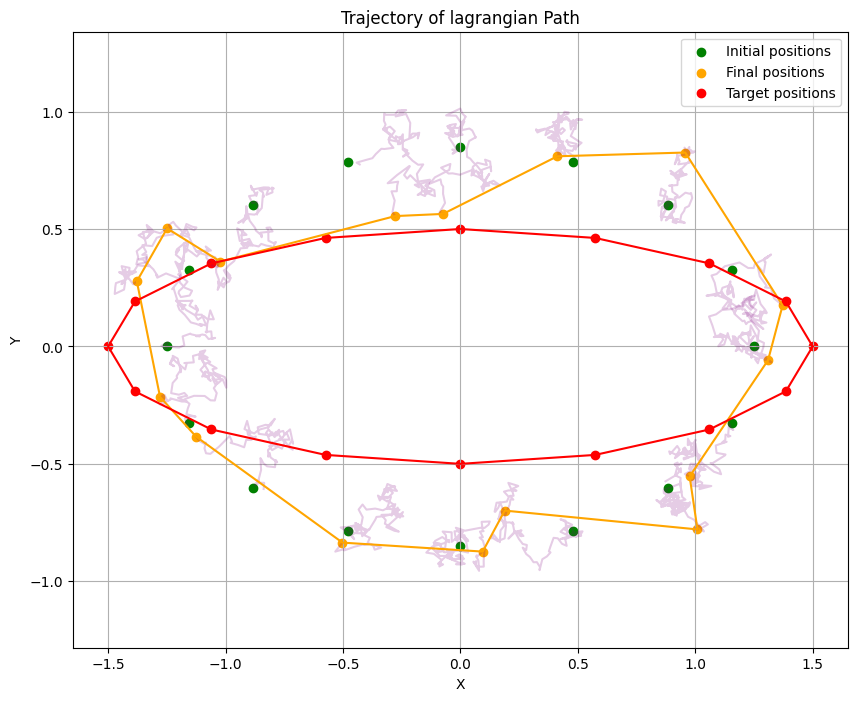

In [35]:
n_train_pts = 16
X0 = Ellipse(a=1.25, b=0.85, shift_x=0.0, shift_y=0.0)
XT = Ellipse(a=1.5, b=0.5, shift_x=0.0, shift_y=0.0)

x0 = X0._eval(n_train_pts)
xT = XT._eval(n_train_pts)
T = 1.0
dt = 1.0e-2
sde_type = "lagrangian"

sde = SDEFactory.create(sde_type, sigma=0.2, kappa=0.25)
wiener = Wiener(W_shape=(n_train_pts * 2, ))
solver = EulerMaruyama(sde, wiener)

path = solver.solve(jax.random.PRNGKey(0), x0, n_batches=1)

# Reshape the data to separate x and y coordinates
xs = path.xs.reshape(1, -1, n_train_pts, 2)

# Create a new figure
plt.figure(figsize=(10, 8))

# Define colors for starting points, trajectories, and endpoints
start_color = 'green'
trajectory_color = 'purple'
end_color = 'orange'
target_color = 'red'

# Plot the trajectory for each point
for i in range(n_train_pts):
    plt.plot(xs[0, :, i, 0], xs[0, :, i, 1], color=trajectory_color, alpha=0.2)

# Plot the initial positions
plt.scatter(x0[:, 0], x0[:, 1], c=start_color, label='Initial positions')

# Plot the final positions
# Plot the final positions as a closed curve
plt.scatter(xs[0, -1, :, 0], xs[0, -1, :, 1], c=end_color, label='Final positions')
plt.plot(jnp.append(xs[0, -1, :, 0], xs[0, -1, 0, 0]), jnp.append(xs[0, -1, :, 1], xs[0, -1, 0, 1]), c=end_color)

# Plot the target positions as a closed curve
plt.scatter(xT[:, 0], xT[:, 1], c=target_color, label='Target positions')
plt.plot(jnp.append(xT[:, 0], xT[0, 0]), jnp.append(xT[:, 1], xT[0, 1]), c=target_color)
plt.title(f'Trajectory of {sde_type} Path')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [36]:
config = {
    "diffusion_bridge":{
        "sde_name": "lagrangian",
        "sde_kwargs": {
            "T": 1.0,
            "sigma": 0.2,
            "kappa": 0.25,
            "W_shape": (int(jnp.prod(jnp.asarray(x0.shape))), )
        },
        "dt": 1.0e-2
    },
    "neural_op": {
        "in_co_dim": 2,
        "out_co_dim": 2,
        "lifting_dim": 16,
        "co_dims_fmults": [1, 2, 4],
        "n_modes_per_layer": [8, 6, 4],
        "act": "gelu",
        "norm": "batch"
    },
    "training": {
        "dir": f"/Users/vbd402/Documents/Projects/scoreoperator/plots/ckpts/{sde_type}_ellipse",
        "seed": 42,
        "n_train_pts": 16,
        "lr": 1.0e-3,
        "clip_grads": False,
        "batch_sz": 16,
        "opt_name": "adam",
        "warmup_steps": 50,
        "train_n_iters": 2000,
        "checkpoint_freq": 200
    }
}

In [37]:
trainer = TrainerModule(config)

In [38]:
trainer.train_model(x0=x0)

Iter 200    / 2000, avg train loss: 71.9499, stage running time: 55.5906s
Model checkpoint saved successfully to /Users/vbd402/Documents/Projects/scoreoperator/plots/ckpts/lagrangian_ellipse/checkpoint_200
Iter 400    / 2000, avg train loss: 70.1231, stage running time: 55.3433s
Model checkpoint saved successfully to /Users/vbd402/Documents/Projects/scoreoperator/plots/ckpts/lagrangian_ellipse/checkpoint_400
Iter 600    / 2000, avg train loss: 69.7354, stage running time: 55.7248s
Model checkpoint saved successfully to /Users/vbd402/Documents/Projects/scoreoperator/plots/ckpts/lagrangian_ellipse/checkpoint_600
Iter 800    / 2000, avg train loss: 69.4200, stage running time: 55.9506s
Model checkpoint saved successfully to /Users/vbd402/Documents/Projects/scoreoperator/plots/ckpts/lagrangian_ellipse/checkpoint_800
Iter 1000   / 2000, avg train loss: 69.1283, stage running time: 55.8232s
Model checkpoint saved successfully to /Users/vbd402/Documents/Projects/scoreoperator/plots/ckpts/lagr

In [39]:
score_model = ScoreModel(trainer)

In [42]:
n_test_pts = 32
x0_test = X0._eval(n_test_pts)
xT_test = XT._eval(n_test_pts)

db_config = {
    "sde_name": "brownian",
    "sde_kwargs": {
        "T": 1.0,
        "sigma": 0.15,
        "W_shape": (int(jnp.prod(jnp.asarray(x0_test.shape))), )
    },
    "dt": 1.0e-2
}
trainer.update_db(db_config)
reverse_path = trainer.db.solve_reverse_bridge(jax.random.PRNGKey(0), xT_test, n_batches=1, model=score_model)

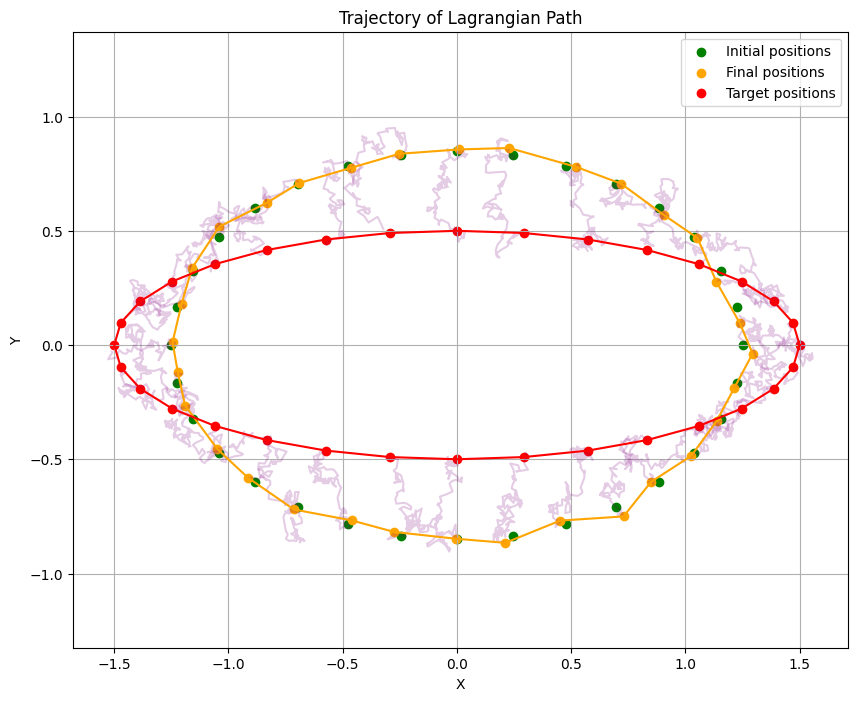

In [43]:
xs = reverse_path.xs.reshape(1, -1, n_test_pts, 2)

# Create a new figure
plt.figure(figsize=(10, 8))

# Define colors for starting points, trajectories, and endpoints
start_color = 'green'
trajectory_color = 'purple'
end_color = 'orange'
target_color = 'red'

# Plot the trajectory for each point
for i in range(n_test_pts):
    plt.plot(xs[0, :, i, 0], xs[0, :, i, 1], color=trajectory_color, alpha=0.2)

# Plot the initial positions
plt.scatter(x0_test[:, 0], x0_test[:, 1], c=start_color, label='Initial positions')

# Plot the final positions
# Plot the final positions as a closed curve
plt.scatter(xs[0, -1, :, 0], xs[0, -1, :, 1], c=end_color, label='Final positions')
plt.plot(jnp.append(xs[0, -1, :, 0], xs[0, -1, 0, 0]), jnp.append(xs[0, -1, :, 1], xs[0, -1, 0, 1]), c=end_color)

# Plot the target positions as a closed curve
plt.scatter(xT_test[:, 0], xT_test[:, 1], c=target_color, label='Target positions')
plt.plot(jnp.append(xT_test[:, 0], xT_test[0, 0]), jnp.append(xT_test[:, 1], xT_test[0, 1]), c=target_color)
plt.title('Trajectory of Lagrangian Path')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

### Ellipsoid

In [77]:
# import pyvista as pv

(1, 100, 32, 3)
(32, 3)
(32, 3)


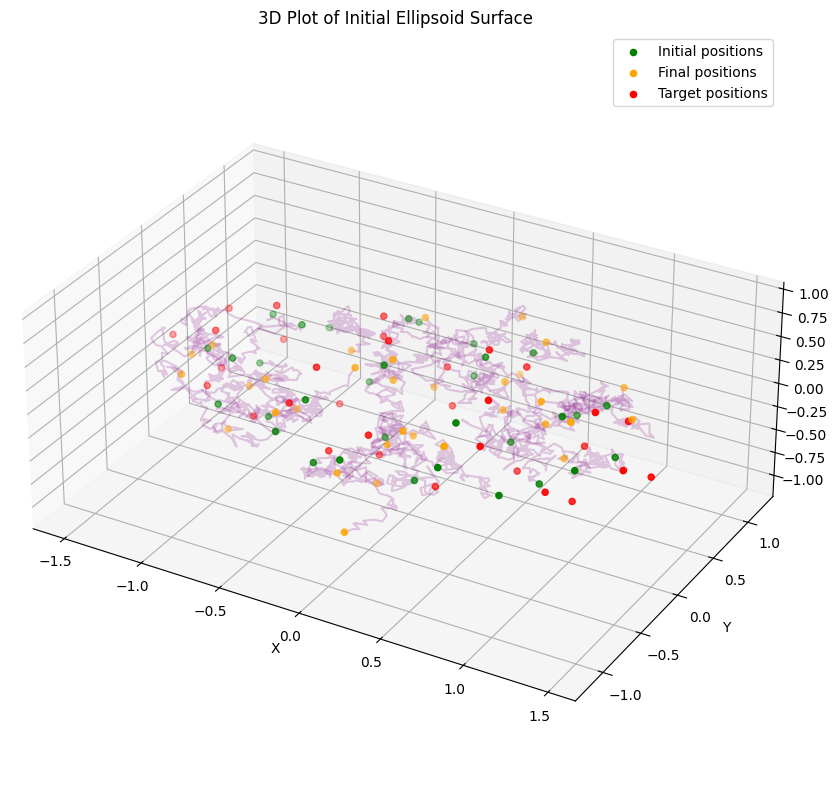

In [44]:
n_train_pts = 32
X0 = Ellipsoid(a=1.25, b=0.85, c=0.5, shift_x=0.0, shift_y=0.0, shift_z=0.0)
XT = Ellipsoid(a=1.5, b=0.5, c=0.7, shift_x=0.0, shift_y=0.0, shift_z=0.0)

x0 = X0.eval(n_train_pts)
xT = XT.eval(n_train_pts)

T = 1.0
dt = 1.0e-2
sde_type = "brownian"

sde = SDEFactory.create(sde_type, sigma=0.3)
wiener = Wiener(W_shape=(n_train_pts * 3, ))
solver = EulerMaruyama(sde, wiener)

path = solver.solve(jax.random.PRNGKey(0), x0, n_batches=1)

# Reshape the data to separate x and y coordinates
xs = path.xs.reshape(1, -1, n_train_pts, 3)
print(xs.shape)
print(x0.shape)
print(xT.shape)

# Create a 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

start_color = 'green'
trajectory_color = 'purple'
end_color = 'orange'
target_color = 'red'

# Plot the trajectory for each point
for i in range(n_train_pts):
    ax.plot(xs[0, :, i, 0], xs[0, :, i, 1], xs[0, :, i, 2], color=trajectory_color, alpha=0.2)

# Plot the initial positions
ax.scatter(x0[:, 0], x0[:, 1], x0[:, 2], c=start_color, label='Initial positions')

# Plot the final positions
ax.scatter(xs[0, -1, :, 0], xs[0, -1, :, 1], xs[0, -1, :, 2], c=end_color, label='Final positions')

# Plot the target positions
ax.scatter(xT[:, 0], xT[:, 1], xT[:, 2], c=target_color, label='Target positions')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot of Initial Ellipsoid Surface')

# Add a legend
ax.legend()

# Ensure equal aspect ratio
ax.set_box_aspect((jnp.ptp(x0[:, 0]), jnp.ptp(x0[:, 1]), jnp.ptp(x0[:, 2])))

# plt.show()

# cloud = pv.PolyData(x0)
# cloud.plot()

# volume = cloud.delaunay_3d(alpha=2.)
# shell = volume.extract_geometry()
# shell.plot()


In [45]:
config = {
    "diffusion_bridge":{
        "sde_name": "lagrangian",
        "sde_kwargs": {
            "T": 1.0,
            "sigma": 0.3,
            "W_shape": (int(jnp.prod(jnp.asarray(x0.shape))), )
        },
        "dt": 1.0e-2
    },
    "neural_op": {
        "in_co_dim": 3,
        "out_co_dim": 3,
        "lifting_dim": 64,
        "co_dims_fmults": [1, 2, 4],
        "n_modes_per_layer": [16, 8, 4],
        "act": "gelu",
        "norm": "batch"
    },
    "training": {
        "dir": f"/Users/vbd402/Documents/Projects/scoreoperator/plots/ckpts/{sde_type}_ellipsoid",
        "seed": 42,
        "n_train_pts": n_train_pts,
        "lr": 1.0e-3,
        "clip_grads": False,
        "batch_sz": 16,
        "opt_name": "adam",
        "warmup_steps": 50,
        "train_n_iters": 2000,
        "checkpoint_freq": 200
    }
}

In [46]:
trainer = TrainerModule(config)

In [47]:
trainer.train_model(x0=x0)

Iter 200    / 2000, avg train loss: 971.3033, stage running time: 1067.0807s
Model checkpoint saved successfully to /Users/vbd402/Documents/Projects/scoreoperator/plots/ckpts/brownian_ellipsoid/checkpoint_200


KeyboardInterrupt: 

In [38]:
score_model = ScoreModel(trainer)

In [42]:
n_test_pts = 32
x0_test = X0.eval(n_test_pts)
xT_test = XT.eval(n_test_pts)

db_config = {
    "sde_name": "brownian",
    "sde_kwargs": {
        "T": 1.0,
        "sigma": 0.2,
        "kappa": 0.25,
        "W_shape": (int(jnp.prod(jnp.asarray(x0_test.shape))), )
    },
    "dt": 1.0e-2
}
trainer.update_db(db_config)
reverse_path = trainer.db.solve_reverse_bridge(jax.random.PRNGKey(0), xT_test, n_batches=1, model=score_model)

(1, 100, 32, 3)
(32, 3)
(32, 3)


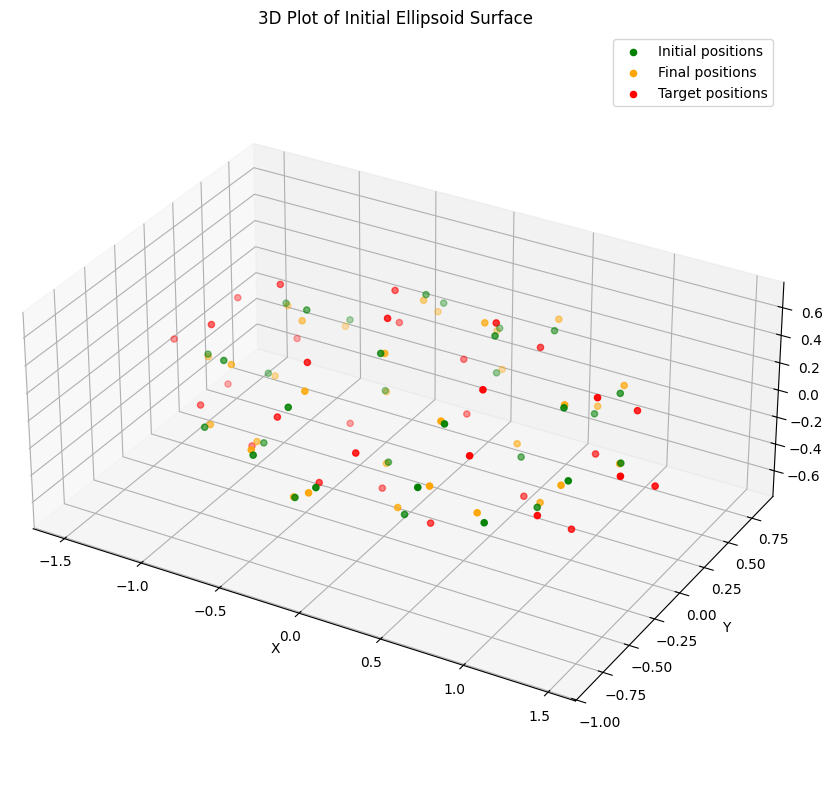

In [43]:
# Reshape the data to separate x and y coordinates
xs = reverse_path.xs.reshape(1, -1, n_test_pts, 3)
print(xs.shape)
print(x0.shape)
print(xT.shape)

# Create a 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

start_color = 'green'
trajectory_color = 'purple'
end_color = 'orange'
target_color = 'red'

# Plot the trajectory for each point
# for i in range(n_test_pts):
#     ax.plot(xs[0, :, i, 0], xs[0, :, i, 1], xs[0, :, i, 2], color=trajectory_color, alpha=0.2)

# Plot the initial positions
ax.scatter(x0_test[:, 0], x0_test[:, 1], x0_test[:, 2], c=start_color, label='Initial positions')

# Plot the final positions
ax.scatter(xs[0, -1, :, 0], xs[0, -1, :, 1], xs[0, -1, :, 2], c=end_color, label='Final positions')

# Plot the target positions
ax.scatter(xT_test[:, 0], xT_test[:, 1], xT_test[:, 2], c=target_color, label='Target positions')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot of Initial Ellipsoid Surface')

# Add a legend
ax.legend()

# Ensure equal aspect ratio
ax.set_box_aspect((jnp.ptp(x0_test[:, 0]), jnp.ptp(x0_test[:, 1]), jnp.ptp(x0_test[:, 2])))